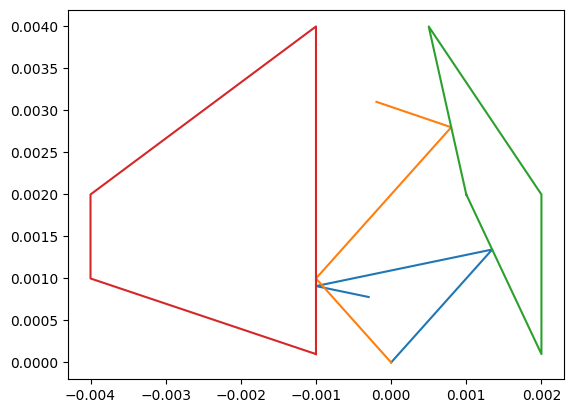

In [24]:
from shapely.geometry import LineString, Polygon, MultiPoint, Point
import numpy as np
import matplotlib.pyplot as plt


# 原点坐标
origin = Point(0, 0)
# 将角度转化为弧度
#angles = [np.deg2rad(angle) for angle in [0, 45, 90, 135, 180, 225, 270, 315]]
angles = [np.deg2rad(angle) for angle in [45, 135]]

# 500米对应的经纬度数值大致是0.0045
#max_distance = 0.0045
# 假设存在一个多边形
polygons = [
            Polygon([(0.001, 0.002), (0.0005, 0.004), (0.002, 0.002), (0.002, 0.0001)]),
            Polygon([(-0.001, 0.0001), (-0.001, 0.004), (-0.004, 0.002), (-0.004, 0.001)]),
            ] 


def find_reflected_ray(ray, polygon, max_distance):
    # 找到交点
    intersections = ray.intersection(polygon.exterior)

    #if intersections.is_empty:
    #    return None  # 返回None表示没有反射

    # 求出交点的坐标
    if isinstance(intersections, Point):
        hit_point = intersections.coords[0]
    elif isinstance(intersections, MultiPoint):
        # 计算所有交点到 ray 的起点的距离，找到最近的那一个
        distances = [distance(ray.coords[0], point.coords[0]) for point in intersections.geoms]
        closest_index = distances.index(min(distances))
        hit_point = intersections.geoms[closest_index].coords[0]

    x, y = ray.coords[0]
    dx_1, dy_1 = np.array([x,y]) - np.array(hit_point)
    length_o_h = np.sqrt(dx_1 ** 2 + dy_1 ** 2)
    if length_o_h < 0.000001:
        return ray,max_distance

    remain_distance = max_distance - length_o_h
    # 找到多边形边的单位法线向量
    #dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    #normal = np.array([dy / length, -dx / length])
    edge_with_hit = find_edge(polygon, hit_point)
    normal = calculate_normal(edge_with_hit)

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + remain_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    return reflected_ray,remain_distance

def find_edge(polygon, hit_point):
    coords = polygon.exterior.coords[:]
    min_distance = float('inf')
    hit_edge = None
    for i in range(len(coords) - 1):
        p1, p2 = coords[i], coords[i + 1]
        line = LineString([p1, p2])
        distance = line.distance(Point(hit_point))
        if distance < min_distance:
            min_distance = distance
            hit_edge = line
    return hit_edge

def calculate_normal(edge):
    dx = edge.coords[-1][0] - edge.coords[0][0]
    dy = edge.coords[-1][1] - edge.coords[0][1]
    length = np.sqrt(dx ** 2 + dy ** 2)
    if dx * dy > 0:
        dx, dy = dy, dx
    return np.array([-dy / length, dx / length]) 

def distance(point1, point2):
    # 使用欧几里德距离公式
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5



def find_ray(ray, polygons, max_distance):
    remain_distance = max_distance
    
    
    for polygon in polygons:
        intersections = ray.intersection(polygon.exterior)

        if not intersections.is_empty:
            ray_copy = ray
            ray, remain_distance = find_reflected_ray(ray, polygon, max_distance)
            if ray_copy == ray:
                continue
            if remain_distance <= 0 : 
                break
            return ray, remain_distance
            

    return ray, remain_distance

def find_and_graph_ray(angle, polygons, origin):
    max_distance = 0.005
    dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
    ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])
    ray_1 = LineString([origin, Point(origin.x + 1, origin.y + 1)])
    end_points = [ray.coords[1]]

    for i in range(10):
        if ray_1 != ray:
            ray,(ray_1, remain_distance) = ray_1, find_ray(ray if i==0 else ray_1, polygons, max_distance if i==0 else remain_distance)
            if ray_1 != ray:
                end_points.pop(0) if i==0 else end_points.pop(-1)
                end_points.extend([ray_1.coords[0], ray_1.coords[1]])

    return end_points 

for angle in angles:
    end_points = find_and_graph_ray(angle, polygons, origin)
    xs, ys = zip(*[(origin.x, origin.y)] + end_points)
    plt.plot(xs, ys)
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()

In [21]:
import json

with open('C:/Users/86900/Desktop/codesign/select_tower.json') as f:
    data = json.load(f)

geometries = [item['geometry'] for item in data['features']]

#for geometry in geometries:
#    print(geometry)
print(geometries[0])
print(len(geometries))
print(len(data))

{'x': -86.22276306199996, 'y': 32.55455017100007}
26
6


In [20]:
import json

with open('C:/Users/86900/Desktop/codesign/alabama_select.json') as f:
    data = json.load(f)

geometries = [item['geometry'] for item in data['features']]

#for geometry in geometries:
#    print(geometry)
print(geometries[0])
print(len(geometries))

{'rings': [[[-86.20712999999995, 32.54643500000003], [-86.20713699999999, 32.546272000000044], [-86.20721999999995, 32.54627500000004], [-86.20721699999996, 32.546354000000065], [-86.20728399999996, 32.54635500000006], [-86.20727999999997, 32.54643900000008], [-86.20712999999995, 32.54643500000003]]]}
1661


In [15]:
import geopandas as gpd

# 将 "file_path" 替换为你的 shp 文件的路径
file_path = "C:/Users/86900/Desktop/codesign/Alabama_select.geojson"
data = gpd.read_file(file_path)

print(data.head())
print(len(data))
all_geometries_list = data['geometry'].tolist()
#polygons = [data.loc[0, 'geometry'],
#            data.loc[1, 'geometry']
#            ] 
print(all_geometries_list)

   OBJECTID  release capture_dates_range  Shape_Length    Shape_Area  \
0         1        2  8/1/2018-10/1/2018      0.000626  1.915500e-08   
1         2        2  8/1/2018-10/1/2018      0.000382  8.868000e-09   
2         3        2  8/1/2018-10/1/2018      0.000476  1.368100e-08   
3         4        2  8/1/2018-10/1/2018      0.000709  2.711600e-08   
4         5        2  8/1/2018-10/1/2018      0.000396  9.585000e-09   

                                            geometry  
0  POLYGON ((-86.20713 32.54644, -86.20728 32.546...  
1  POLYGON ((-86.20746 32.54346, -86.20747 32.543...  
2  POLYGON ((-86.20806 32.54601, -86.20792 32.546...  
3  POLYGON ((-86.20958 32.54281, -86.20957 32.542...  
4  POLYGON ((-86.21008 32.54878, -86.21007 32.548...  
1661
[<POLYGON ((-86.207 32.546, -86.207 32.546, -86.207 32.546, -86.207 32.546, -...>, <POLYGON ((-86.207 32.543, -86.207 32.544, -86.208 32.544, -86.208 32.543, -...>, <POLYGON ((-86.208 32.546, -86.208 32.546, -86.208 32.546, -86.208 

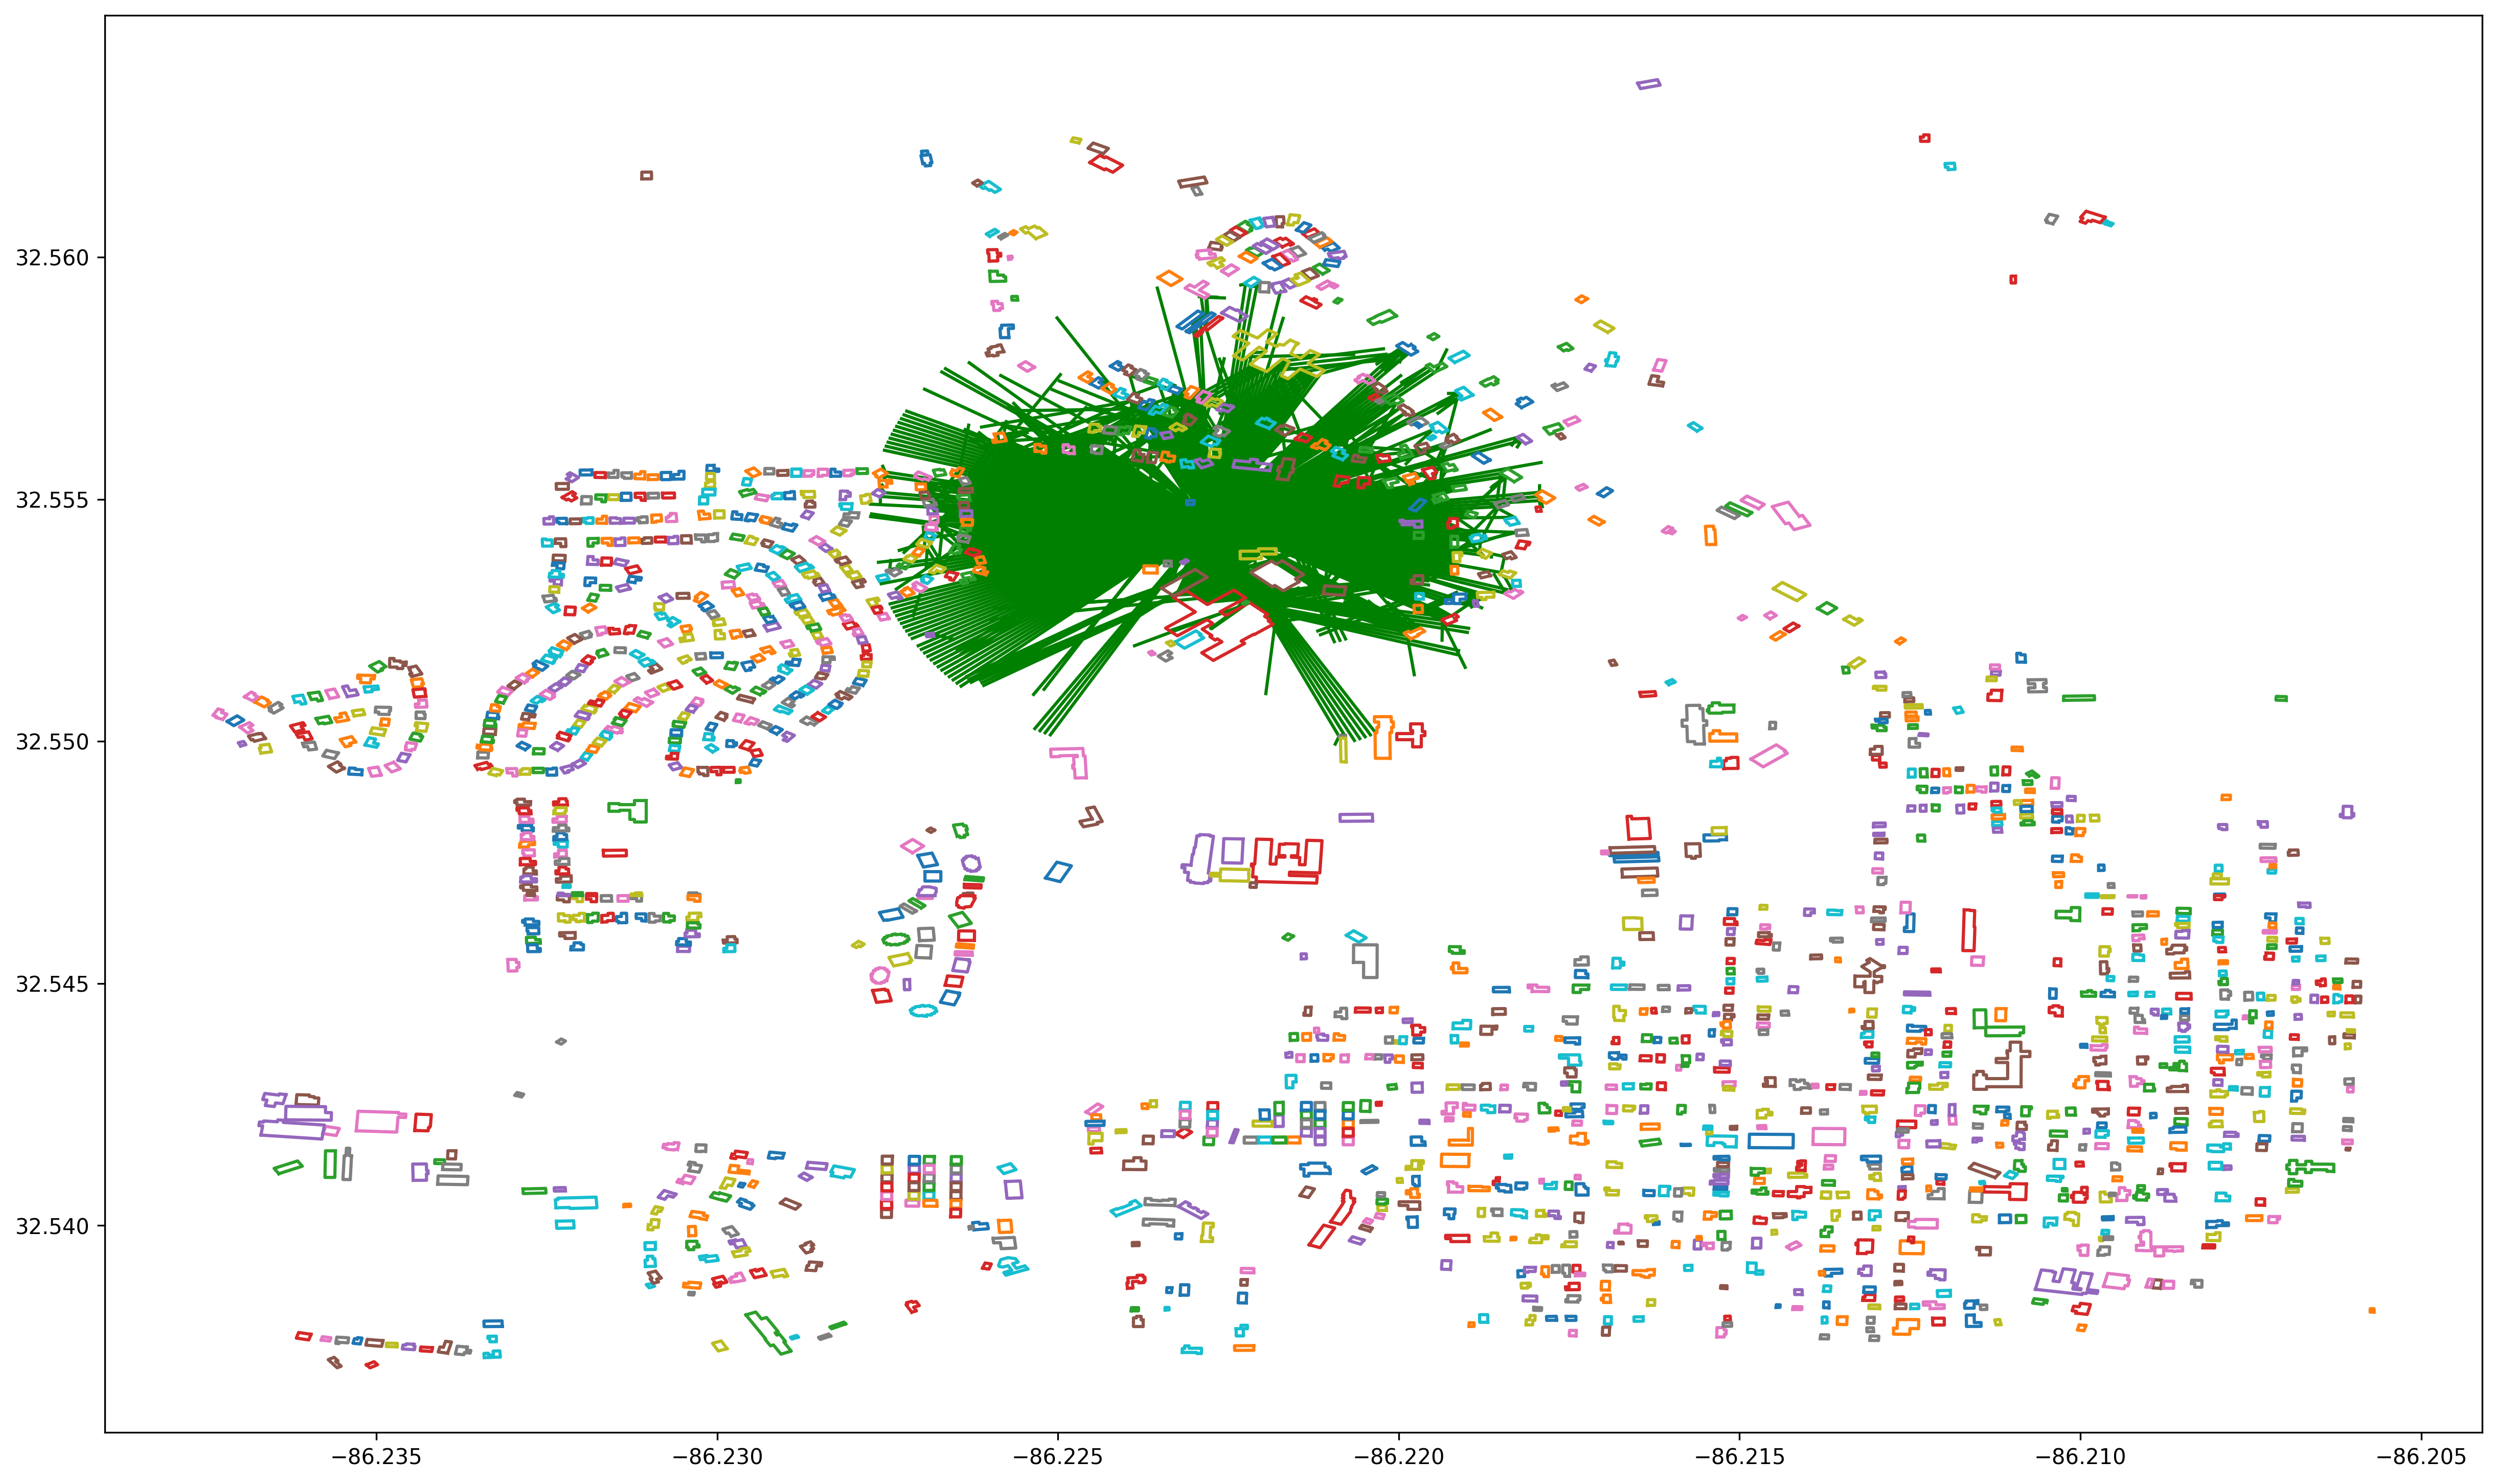

In [15]:
from shapely.geometry import LineString, Polygon, MultiPoint, Point
import numpy as np
import matplotlib.pyplot as plt
import json
import geopandas as gpd
from matplotlib.collections import LineCollection
import geojson
import matplotlib.cm as cm

with open('C:/Users/86900/Desktop/codesign/select_tower.json') as f:
    data_tower = json.load(f)
geometries = [item['geometry'] for item in data_tower['features']]

file_path = "C:/Users/86900/Desktop/codesign/Alabama_select.geojson"
data_building = gpd.read_file(file_path)

# 原点坐标
#origin = Point(0, 0)
origin = Point(geometries[0]['x'], geometries[0]['y'])
# 将角度转化为弧度
#angles = [np.deg2rad(angle) for angle in [0, 30, 45, 60, 90,115, 135,150, 180,215, 225,250, 270,295, 315,335]]
angles = [np.deg2rad(angle) for angle in list(range(0, 360))]
#angles = [np.deg2rad(angle) for angle in [45, 135]]

# 500米对应的经纬度数值大致是0.0045
#max_distance = 0.0045
# 假设存在一个多边形
#polygons = [Polygon([(0.001, 0.002), (0.002, 0.0001), (0.002, 0.002), (0.0005, 0.004)]),
#            Polygon([(-0.001, 0.0001), (-0.001, 0.004), (-0.004, 0.002), (-0.004, 0.001)]),
#            ]
polygons = data_building['geometry'].tolist()


def find_reflected_ray(ray, polygon, max_distance):
    # 找到交点
    intersections = ray.intersection(polygon.exterior)

    #if intersections.is_empty:
    #    return None  # 返回None表示没有反射

    # 求出交点的坐标
    if isinstance(intersections, Point):
        hit_point = intersections.coords[0]
    elif isinstance(intersections, MultiPoint):
        # 计算所有交点到 ray 的起点的距离，找到最近的那一个
        distances = [distance(ray.coords[0], point.coords[0]) for point in intersections.geoms]
        closest_index = distances.index(min(distances))
        hit_point = intersections.geoms[closest_index].coords[0]

    x, y = ray.coords[0]
    dx_1, dy_1 = np.array([x,y]) - np.array(hit_point)
    length_o_h = np.sqrt(dx_1 ** 2 + dy_1 ** 2)
    if length_o_h < 0.000001:
        return ray,max_distance

    remain_distance = max_distance - length_o_h
    # 找到多边形边的单位法线向量
    #dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    #normal = np.array([dy / length, -dx / length])
    edge_with_hit = find_edge(polygon, hit_point)
    normal = calculate_normal(edge_with_hit)

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + remain_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    return reflected_ray,remain_distance

def find_edge(polygon, hit_point):
    coords = polygon.exterior.coords[:]
    min_distance = float('inf')
    hit_edge = None
    for i in range(len(coords) - 1):
        p1, p2 = coords[i], coords[i + 1]
        line = LineString([p1, p2])
        distance = line.distance(Point(hit_point))
        if distance < min_distance:
            min_distance = distance
            hit_edge = line
    return hit_edge

def calculate_normal(edge):
    dx = edge.coords[-1][0] - edge.coords[0][0]
    dy = edge.coords[-1][1] - edge.coords[0][1]
    length = np.sqrt(dx ** 2 + dy ** 2)
    if dx * dy > 0:
        dx, dy = dy, dx
    return np.array([-dy / length, dx / length]) 

def distance(point1, point2):
    # 使用欧几里德距离公式
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5



def find_ray(ray, polygons, max_distance):
    remain_distance = max_distance
    
    
    for polygon in polygons:
        intersections = ray.intersection(polygon.exterior)

        if not intersections.is_empty:
            ray_copy = ray
            ray, remain_distance = find_reflected_ray(ray, polygon, max_distance)
            if ray_copy == ray:
                continue
            if remain_distance <= 0 : 
                break
            return ray, remain_distance
            

    return ray, remain_distance

def find_and_graph_ray(angle, polygons, origin):
    max_distance = 0.005
    dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
    ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])
    ray_1 = LineString([origin, Point(origin.x + 1, origin.y + 1)])
    end_points = [ray.coords[1]]

    for i in range(10):
        if ray_1 != ray:
            ray,(ray_1, remain_distance) = ray_1, find_ray(ray if i==0 else ray_1, polygons, max_distance if i==0 else remain_distance)
            if ray_1 != ray:
                end_points.pop(0) if i==0 else end_points.pop(-1)
                end_points.extend([ray_1.coords[0], ray_1.coords[1]])

    return end_points 
segments = []

fig, ax = plt.subplots(figsize=(20, 12), dpi=300)
for angle in angles:
    end_points = find_and_graph_ray(angle, polygons, origin)
    xs, ys = zip(*[(origin.x, origin.y)] + end_points)
    #for end_point in end_points:   # 如果 end_points 包含多个端点，那就创建多条线段
        #segments.append([ [origin.x, origin.y], [end_point[0], end_point[1]]])
    plt.plot(xs, ys,'g')
## 创建 LineCollection 对象
#lc = LineCollection(segments, cmap='viridis')
#lc.set_array(np.linspace(0, 1, len(segments)))   # 这里修改了 len(segments) 
#ax.add_collection(lc)
#ax.autoscale_view()
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()
#fig.savefig("output.png", dpi=300)


In [ ]:
from shapely.geometry import LineString, Polygon, MultiPoint, Point
import numpy as np
import matplotlib.pyplot as plt
import json
import geopandas as gpd
from matplotlib.collections import LineCollection
import geojson
import matplotlib.cm as cm

with open('C:/Users/86900/Desktop/codesign/select_tower.json') as f:
    data_tower = json.load(f)
geometries = [item['geometry'] for item in data_tower['features']]

file_path = "C:/Users/86900/Desktop/codesign/Alabama_select.geojson"
data_building = gpd.read_file(file_path)

# 原点坐标
#origin = Point(0, 0)
origin = Point(geometries[0]['x'], geometries[0]['y'])
# 将角度转化为弧度
#angles = [np.deg2rad(angle) for angle in [0, 30, 45, 60, 90,115, 135,150, 180,215, 225,250, 270,295, 315,335]]
angles = [np.deg2rad(angle) for angle in list(range(0, 360,))]
#angles = [np.deg2rad(angle) for angle in [45, 135]]

# 500米对应的经纬度数值大致是0.0045
#max_distance = 0.0045
# 假设存在一个多边形
#polygons = [Polygon([(0.001, 0.002), (0.002, 0.0001), (0.002, 0.002), (0.0005, 0.004)]),
#            Polygon([(-0.001, 0.0001), (-0.001, 0.004), (-0.004, 0.002), (-0.004, 0.001)]),
#            ]
polygons = data_building['geometry'].tolist()


def find_reflected_ray(ray, polygon, max_distance):
    # 找到交点
    intersections = ray.intersection(polygon.exterior)

    #if intersections.is_empty:
    #    return None  # 返回None表示没有反射

    # 求出交点的坐标
    if isinstance(intersections, Point):
        hit_point = intersections.coords[0]
    elif isinstance(intersections, MultiPoint):
        # 计算所有交点到 ray 的起点的距离，找到最近的那一个
        distances = [distance(ray.coords[0], point.coords[0]) for point in intersections.geoms]
        closest_index = distances.index(min(distances))
        hit_point = intersections.geoms[closest_index].coords[0]

    x, y = ray.coords[0]
    dx_1, dy_1 = np.array([x,y]) - np.array(hit_point)
    length_o_h = np.sqrt(dx_1 ** 2 + dy_1 ** 2)
    if length_o_h < 0.000001:
        return ray,max_distance

    remain_distance = max_distance - length_o_h
    # 找到多边形边的单位法线向量
    #dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    #normal = np.array([dy / length, -dx / length])
    edge_with_hit = find_edge(polygon, hit_point)
    normal = calculate_normal(edge_with_hit)

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + remain_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    return reflected_ray,remain_distance

def find_edge(polygon, hit_point):
    coords = polygon.exterior.coords[:]
    min_distance = float('inf')
    hit_edge = None
    for i in range(len(coords) - 1):
        p1, p2 = coords[i], coords[i + 1]
        line = LineString([p1, p2])
        distance = line.distance(Point(hit_point))
        if distance < min_distance:
            min_distance = distance
            hit_edge = line
    return hit_edge

def calculate_normal(edge):
    dx = edge.coords[-1][0] - edge.coords[0][0]
    dy = edge.coords[-1][1] - edge.coords[0][1]
    length = np.sqrt(dx ** 2 + dy ** 2)
    if dx * dy > 0:
        dx, dy = dy, dx
    return np.array([-dy / length, dx / length]) 

def distance(point1, point2):
    # 使用欧几里德距离公式
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5



def find_ray(ray, polygons, max_distance):
    remain_distance = max_distance
    
    
    for polygon in polygons:
        intersections = ray.intersection(polygon.exterior)

        if not intersections.is_empty:
            ray_copy = ray
            ray, remain_distance = find_reflected_ray(ray, polygon, max_distance)
            if ray_copy == ray:
                continue
            if remain_distance <= 0 : 
                break
            return ray, remain_distance
            

    return ray, remain_distance

def find_and_graph_ray(angle, polygons, origin):
    max_distance = 0.005
    dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
    ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])
    ray_1 = LineString([origin, Point(origin.x + 1, origin.y + 1)])
    end_points = [ray.coords[1]]

    for i in range(10):
        if ray_1 != ray:
            ray,(ray_1, remain_distance) = ray_1, find_ray(ray if i==0 else ray_1, polygons, max_distance if i==0 else remain_distance)
            if ray_1 != ray:
                end_points.pop(0) if i==0 else end_points.pop(-1)
                end_points.extend([ray_1.coords[0], ray_1.coords[1]])

    return end_points 
segments = []
features = []

fig, ax = plt.subplots(figsize=(20, 12), dpi=300)
for i in range(len(geometries)):
    
    origin = Point(geometries[i]['x'], geometries[i]['y'])
    for angle in angles:
        end_points = find_and_graph_ray(angle, polygons, origin)
        xs, ys = zip(*[(origin.x, origin.y)] + end_points)
        coordinates = list(zip(xs, ys))
        # 建立一个 LineString对象
        line = geojson.LineString(coordinates)
    
        # 这个 LineString 构成了 Feature 对象中的几何元素
        feature = geojson.Feature(geometry=line)
        features.append(feature)
        #for end_point in end_points:   # 如果 end_points 包含多个端点，那就创建多条线段
            #segments.append([ [origin.x, origin.y], [end_point[0], end_point[1]]])
        
        plt.plot(xs, ys,'g')
feature_collection = geojson.FeatureCollection(features)

# 将 geojson 对象转化为字符串
dump = geojson.dumps(feature_collection, sort_keys=True)

# 写入 GeoJSON 文件
with open('line.geojson', 'w') as f:
    f.write(dump)
## 创建 LineCollection 对象
#lc = LineCollection(segments, cmap='viridis')
#lc.set_array(np.linspace(0, 1, len(segments)))   # 这里修改了 len(segments) 
#ax.add_collection(lc)
#ax.autoscale_view()
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()
#fig.savefig("output.png", dpi=300)


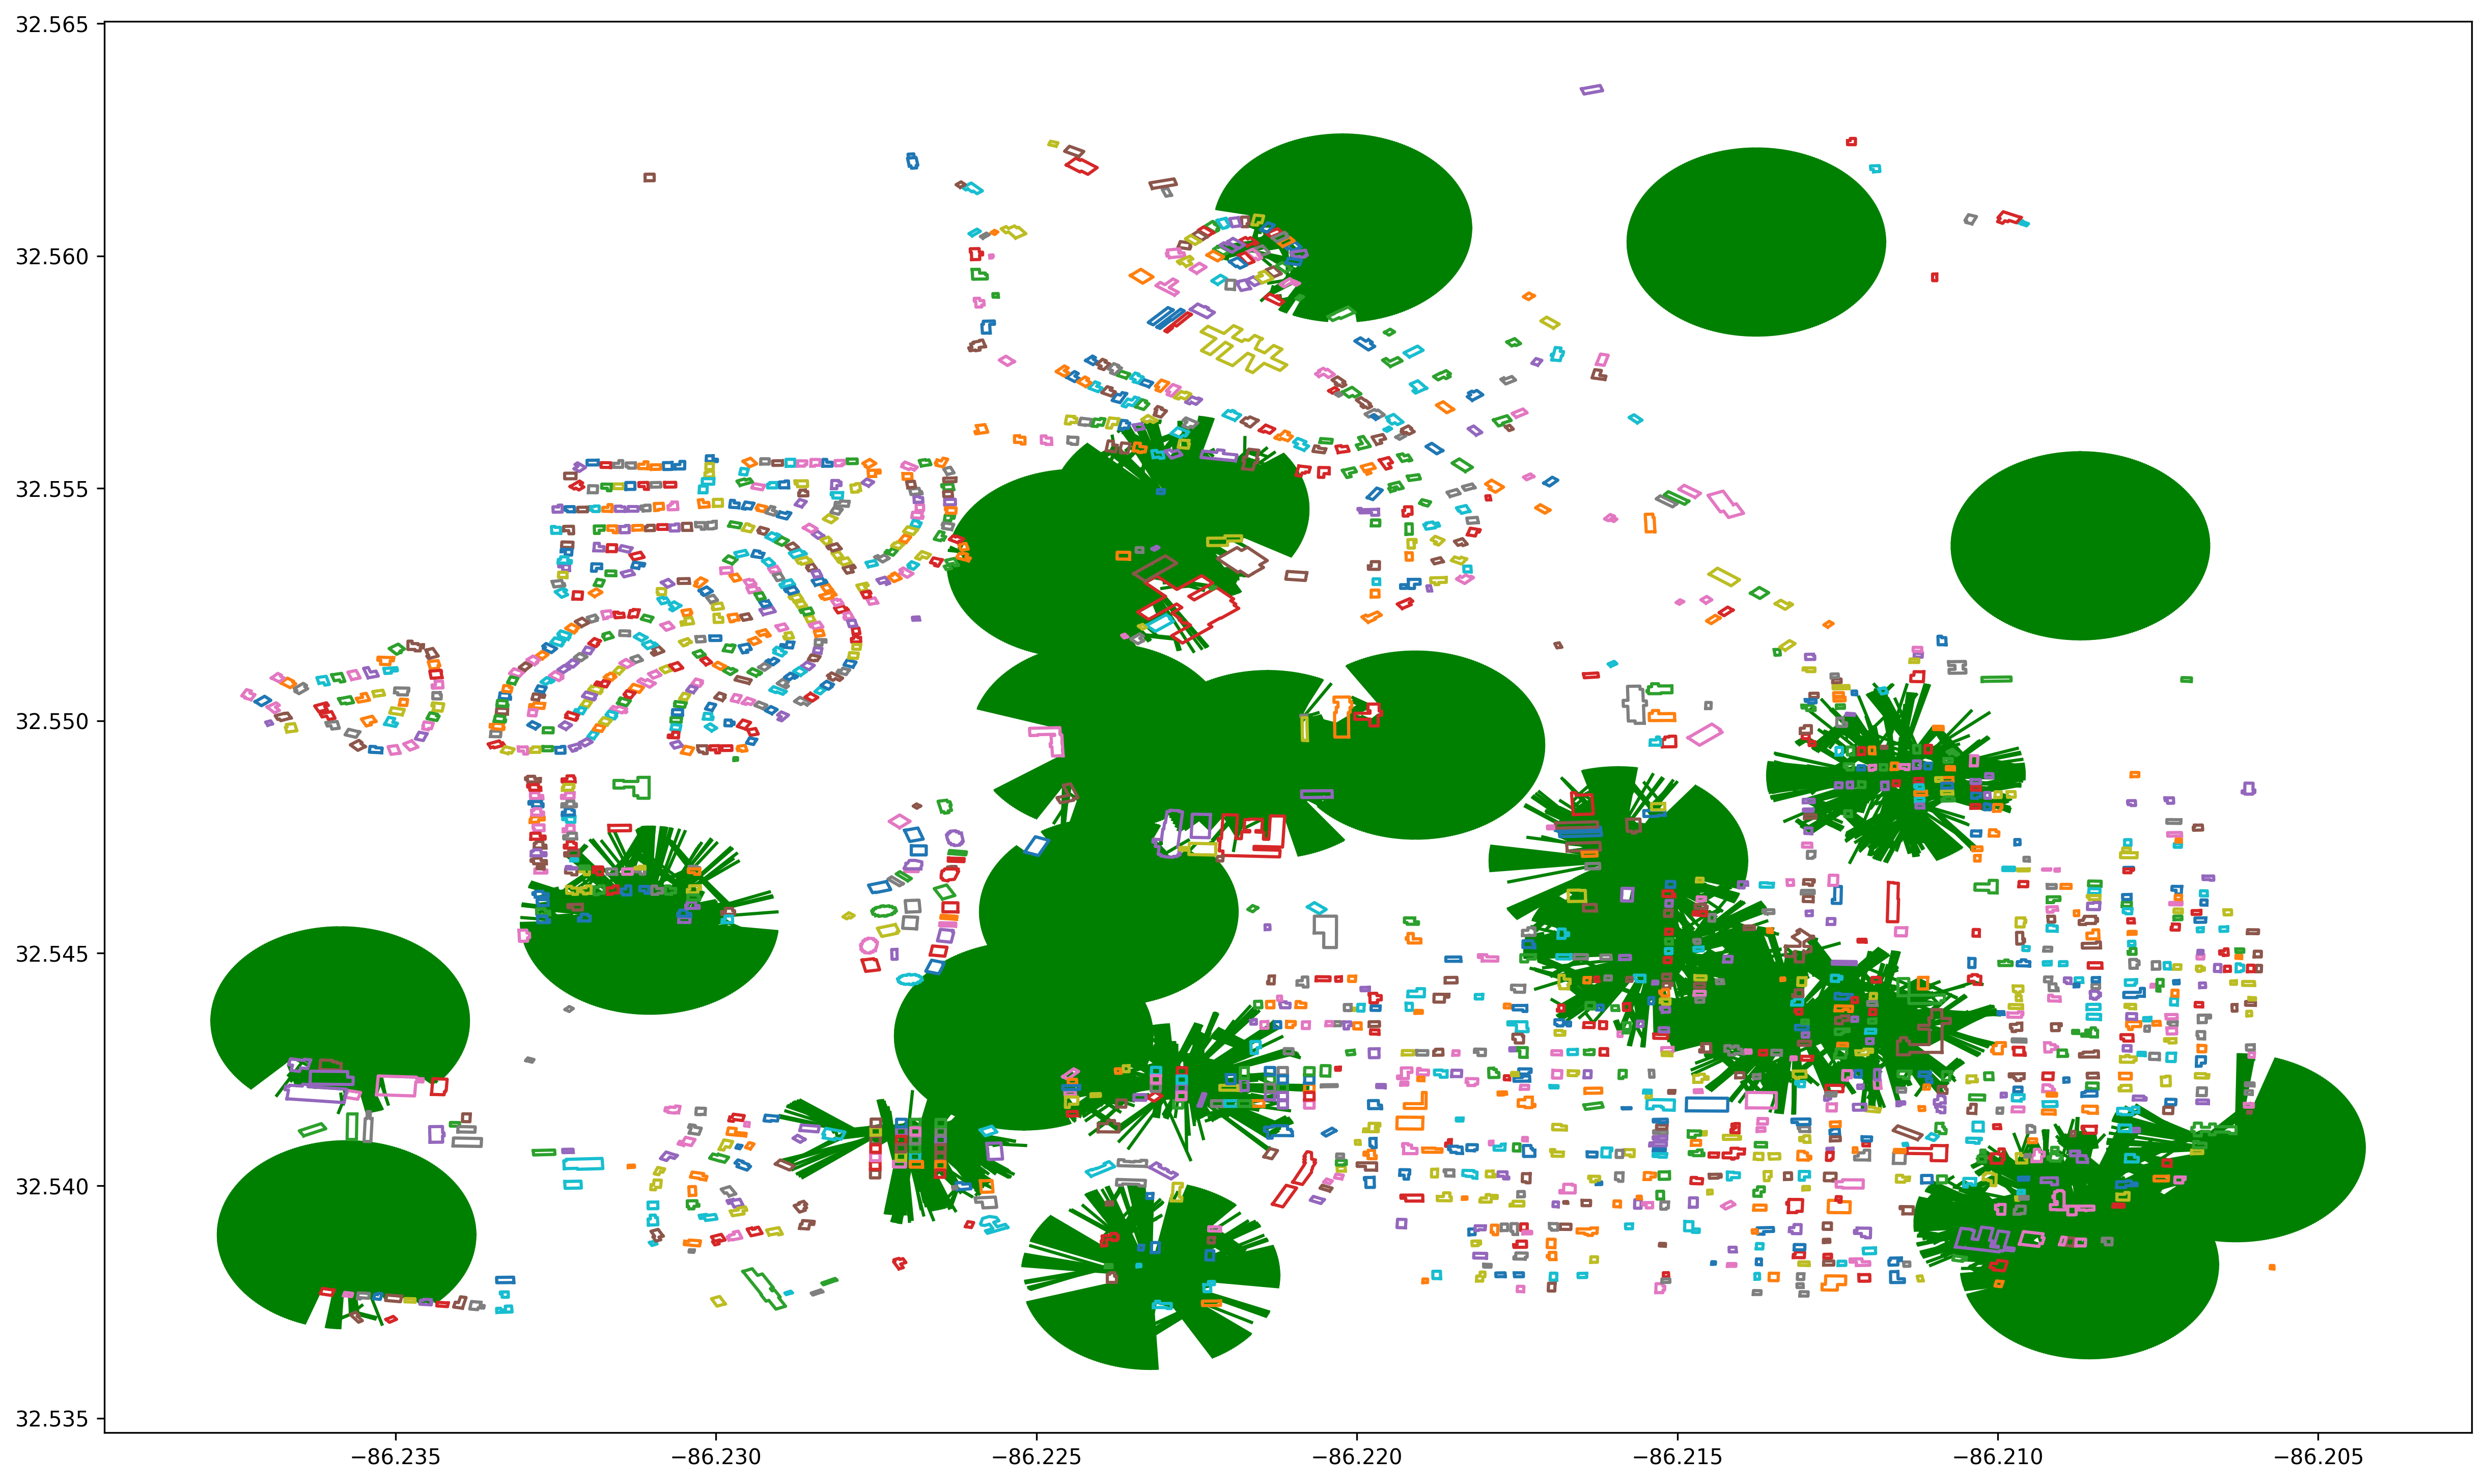

In [2]:
from shapely.geometry import LineString, Polygon, MultiPoint, Point
import numpy as np
import matplotlib.pyplot as plt
import json
import geopandas as gpd
from matplotlib.collections import LineCollection
import geojson
import matplotlib.cm as cm

with open('C:/Users/86900/Desktop/codesign/select_tower.json') as f:
    data_tower = json.load(f)
geometries = [item['geometry'] for item in data_tower['features']]

file_path = "C:/Users/86900/Desktop/codesign/Alabama_select.geojson"
data_building = gpd.read_file(file_path)

# 原点坐标
#origin = Point(0, 0)
origin = Point(geometries[0]['x'], geometries[0]['y'])
# 将角度转化为弧度
#angles = [np.deg2rad(angle) for angle in [0, 30, 45, 60, 90,115, 135,150, 180,215, 225,250, 270,295, 315,335]]
angles = [np.deg2rad(angle) for angle in list(range(0, 360,))]
#angles = [np.deg2rad(angle) for angle in [45, 135]]

# 500米对应的经纬度数值大致是0.0045
#max_distance = 0.0045
# 假设存在一个多边形
#polygons = [Polygon([(0.001, 0.002), (0.002, 0.0001), (0.002, 0.002), (0.0005, 0.004)]),
#            Polygon([(-0.001, 0.0001), (-0.001, 0.004), (-0.004, 0.002), (-0.004, 0.001)]),
#            ]
polygons = data_building['geometry'].tolist()


def find_reflected_ray(ray, polygon, max_distance):
    # 找到交点
    intersections = ray.intersection(polygon.exterior)

    #if intersections.is_empty:
    #    return None  # 返回None表示没有反射

    # 求出交点的坐标
    if isinstance(intersections, Point):
        hit_point = intersections.coords[0]
    elif isinstance(intersections, MultiPoint):
        # 计算所有交点到 ray 的起点的距离，找到最近的那一个
        distances = [distance(ray.coords[0], point.coords[0]) for point in intersections.geoms]
        closest_index = distances.index(min(distances))
        hit_point = intersections.geoms[closest_index].coords[0]

    x, y = ray.coords[0]
    dx_1, dy_1 = np.array([x,y]) - np.array(hit_point)
    length_o_h = np.sqrt(dx_1 ** 2 + dy_1 ** 2)
    if length_o_h < 0.000001:
        return ray,max_distance

    remain_distance = max_distance - length_o_h
    # 找到多边形边的单位法线向量
    #dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    #normal = np.array([dy / length, -dx / length])
    edge_with_hit = find_edge(polygon, hit_point)
    normal = calculate_normal(edge_with_hit)

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + remain_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    return reflected_ray,remain_distance

def find_edge(polygon, hit_point):
    coords = polygon.exterior.coords[:]
    min_distance = float('inf')
    hit_edge = None
    for i in range(len(coords) - 1):
        p1, p2 = coords[i], coords[i + 1]
        line = LineString([p1, p2])
        distance = line.distance(Point(hit_point))
        if distance < min_distance:
            min_distance = distance
            hit_edge = line
    return hit_edge

def calculate_normal(edge):
    dx = edge.coords[-1][0] - edge.coords[0][0]
    dy = edge.coords[-1][1] - edge.coords[0][1]
    length = np.sqrt(dx ** 2 + dy ** 2)
    if dx * dy > 0:
        dx, dy = dy, dx
    return np.array([-dy / length, dx / length]) 

def distance(point1, point2):
    # 使用欧几里德距离公式
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5



def find_ray(ray, polygons, max_distance):
    remain_distance = max_distance
    
    
    for polygon in polygons:
        intersections = ray.intersection(polygon.exterior)

        if not intersections.is_empty:
            ray_copy = ray
            ray, remain_distance = find_reflected_ray(ray, polygon, max_distance)
            if ray_copy == ray:
                continue
            if remain_distance <= 0 : 
                break
            return ray, remain_distance
            

    return ray, remain_distance

def find_and_graph_ray(angle, polygons, origin):
    max_distance = 0.002
    dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
    ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])
    ray_1 = LineString([origin, Point(origin.x + 1, origin.y + 1)])
    end_points = [ray.coords[1]]

    for i in range(10):
        if ray_1 != ray:
            ray,(ray_1, remain_distance) = ray_1, find_ray(ray if i==0 else ray_1, polygons, max_distance if i==0 else remain_distance)
            if ray_1 != ray:
                end_points.pop(0) if i==0 else end_points.pop(-1)
                end_points.extend([ray_1.coords[0], ray_1.coords[1]])

    return end_points 
segments = []
features = []

fig, ax = plt.subplots(figsize=(20, 12), dpi=300)
for i in range(len(geometries)):
    
    origin = Point(geometries[i]['x'], geometries[i]['y'])
    for angle in angles:
        end_points = find_and_graph_ray(angle, polygons, origin)
        xs, ys = zip(*[(origin.x, origin.y)] + end_points)
        coordinates = list(zip(xs, ys))
        # 建立一个 LineString对象
        line = geojson.LineString(coordinates)
    
        # 这个 LineString 构成了 Feature 对象中的几何元素
        feature = geojson.Feature(geometry=line)
        features.append(feature)
        #for end_point in end_points:   # 如果 end_points 包含多个端点，那就创建多条线段
            #segments.append([ [origin.x, origin.y], [end_point[0], end_point[1]]])
        
        plt.plot(xs, ys,'g')
feature_collection = geojson.FeatureCollection(features)

# 将 geojson 对象转化为字符串
dump = geojson.dumps(feature_collection, sort_keys=True)

# 写入 GeoJSON 文件
with open('line.geojson', 'w') as f:
    f.write(dump)
## 创建 LineCollection 对象
#lc = LineCollection(segments, cmap='viridis')
#lc.set_array(np.linspace(0, 1, len(segments)))   # 这里修改了 len(segments) 
#ax.add_collection(lc)
#ax.autoscale_view()
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()
#fig.savefig("output.png", dpi=300)
